# Classification

## MNIST

In this chapter we will be using the MNIST dataset, a set of 70k small images of digits handwritten by HS students and US employees. Each image is labeled with the digit it represents.
This dataset is considered the "Hello world" of Machine Learning.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them.
The following code fetches the MNIST dataset

In [51]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

- A DESCR key describing the dataset
- A data key  containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [52]:
# let's look at these arrays:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70k images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a peek at one digit from the dataset. All you need to do is to grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's imshow() function:

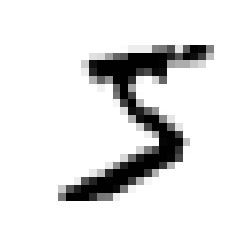

In [53]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

This looks like a 5 and indeed that's what the label tells us
Note that the label is a string. We prefer numbers, so let's cast y to ingegers:

In [54]:
import numpy as np
print(y[0])
y = y.astype(np.uint8)

5


But wait! You should always create a ttest set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into training set (the first 60k images) and a test set (the last 10k images):

In [55]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algos are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit -- for example, the number 5. This "5-detector" will be an example of a *binary classifier* capable of distinguishing between two classes, 5 and NOT 5. Let's create the target vectors for this classification task:

In [56]:
y_train_5 = (y_train == 5)  #Boolean vector, True for 5s, False for all other digits
y_test = (y_test == 5)

Okay, now let's pick a classifier and train it, A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier, using Scikit-Learn's SGDClassifier class.

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training istances independently, one at a time (which also makes SGD well suited for *online learning*), as we will see later. 

Let's create an SGDClassifier and train it on the whole training set:

In [57]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
"""
The SGDClassifier relies on randomness during training (hence the name stochastic). 
If you want reproducible results, you should set the random_state parameter
"""
# Now you can use it to detect images of the number 5:
print(sgd_clf.predict([some_digit]))

[False]


## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many peformance measures available.

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation.

#### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement cross-validation yourself; it is actually fairly straightforward. The following code does roughly the same thing as Scikit-Learn's cross_val_score() function, and prints the same result:

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits = 3, random_state = 42) # nsplits = 3 --> 3fold CV
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # get fresh copy of predictor
    clone_clf = clone(sgd_clf)
    """
    from clone doc
    
    Constructs a new estimator with the same parameters.

    Clone does a deep copy of the model in an estimator without actually copying attached data. 
    It yields a new estimator with the same parameters that has not been fit on any data.
    """
    # set training and testing subset iteration
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # fit predictor for iteration
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))    

0.9532
0.95125
0.9625


The StratifiedKFold class performs stratified sampling to produce folds that contain representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let's use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds:

In [59]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9532 , 0.95125, 0.9625 ])

Over 95% *accuracy* (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn't it? Well, before you get too excited, let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [60]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    # do nothing for fit
    def fit(self, X, y = None):
        pass
    # predict everything as false
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)
# can you guess this model's accuracy? Let's find out:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

That's right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image in *not* a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e. when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*.
The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and the 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You coul make predictions on the test set, but let's keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).
Instead, you can  use the cross_val_predict() function:

In [61]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the (mean) evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*): 52992 were predicted correctly as non-5 images (TRUE NEGATIVES), while the remaining 1587 were wrongly classified as 5s (FALSE POSITIVES). The second row considers the images of 5s (the *positive class*): 1074 were wrongly classified as non-5s (FALSE NEGATIVES), while the remaining 4347 were correctly classified as 5s (TRUE POSITIVES). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right): 

In [63]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look is the accuracy of the positive predictions; this is called the *precision* of the classifier: precision = TP /(TP + FP)

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typicallyused along with another metric named *recall*, also called *sensitivity* or *true positive rate*: recall = TP / (TP + FN)

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [64]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7325581395348837
0.8018815716657444


Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 73% of the time. Moreover, it only detects 80% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.
F1 = 2 x (precision x recall)/(precision + recall)

To compute the F1 score, simply call the f1_score() function:

In [65]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases you may even want to add a human pipeline to check the classifier's video selection). 

On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall tradeoff*.

### Precision/Recall Tradeoff

To understand this tradeoff, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold it assigns the instance to the positive class, or else it assigns it to the negative class.

Moving this decision threshold* we can control the precision/recall tradeoff.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [66]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
"""
The SGDClassifier uses a threshold equal to 0, 
so the previous code returns the same result as the predict() method (i.e. False).
Let's lower the threshold
"""
threshold = -50000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-45148.19955869]
[False]
[ True]


Now how do you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [67]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

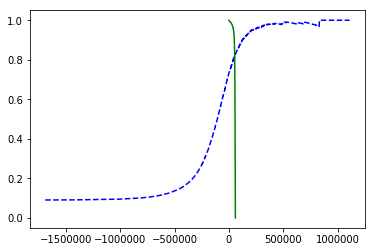

In [68]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
"""
Finally, you can plot precision and recall as functions of the threshold value using Matplotlib
"""
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(recalls[:-1], "g-", label = "Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

## PAG 97

